In [88]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
%matplotlib inline
sns.set(color_codes=True)

# Loading data

In [89]:
PICKLE_TRAIN_DIR=os.path.join("..", 'processed_data', 'train_data.pkl')
PICKLE_PRICING_DIR=os.path.join("..", 'processed_data', 'pricing_data.pkl')

In [90]:
train_data=pd.read_pickle(PICKLE_TRAIN_DIR)
pricing_data=pd.read_pickle(PICKLE_PRICING_DIR)

In [91]:
#merge two dataframes
train=pd.merge(train_data, pricing_data, on='id')

In [92]:
train.dtypes

id                           object
cons_12m                    float64
cons_gas_12m                float64
cons_last_month             float64
forecast_cons_12m           float64
forecast_discount_energy    float64
forecast_meter_rent_12m     float64
forecast_price_energy_p1    float64
forecast_price_energy_p2    float64
forecast_price_pow_p1       float64
has_gas                       int64
imp_cons                    float64
margin_gross_pow_ele        float64
margin_net_pow_ele          float64
nb_prod_act                   int64
net_margin                  float64
pow_max                     float64
churn                         int64
tenure_year                   int32
months_activ                float64
months_to_end               float64
months_modif_prod           float64
months_renewal              float64
channel_epu                   uint8
channel_ewp                   uint8
channel_fix                   uint8
channel_foo                   uint8
channel_lmk                 

# Splitting data

In [93]:
X=train.drop(columns=['id','churn'],axis=1)
y=train['churn']

In [94]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18)

# Modeling (XGBoost)

In [95]:
model=xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=500, random_state=18)
result=model.fit(X_train, y_train)

C:\Users\12024\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:40:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Model evaluation

## Accuracy, precision, recall

In [96]:
def evaluate(model_, X_test_, y_test_):
    prediction_test_=model_.predict(X_test_)
    
    results= pd.DataFrame({'Accuracy': [metrics.accuracy_score(y_test_, prediction_test_)],
                          'Precision': [metrics.precision_score(y_test_, prediction_test_)],
                          'Recall': [metrics.recall_score(y_test_, prediction_test_)]})
    return results

In [97]:
evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall
0,0.906561,0.73494,0.146988


## ROC-AUC

In [98]:
def calcuate_plot_roc_auc(model_, X_test_, y_test_):
    
    # model preduction for the class 1(churn)
    prediction_test_=model_.predict_proba(X_test_)[:,1]
    # compute roc-auc
    fpr, tpr, thresholds= metrics.roc_curve(y_test_, prediction_test_)
    auc_score=metrics.auc(fpr, tpr)
    
    # plot roc curve 
    f,ax=plt.subplots()
    ax.plot(fpr,tpr, label='AUC=%0.2f'%(auc_score))
    # plot the random line 
    plt.plot([0,1],[0,1],label='random')
    ax.set_xlabel('False positive rate (FPR)')
    ax.set_ylabel('True postive rate (TPR)')
    ax.set_title('ROC Curve')
    plt.legend()
    plt.show()
    return print('The AUC score is %f' % auc_score)

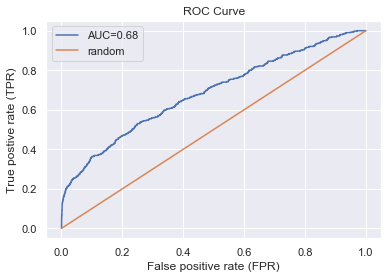

The AUC score is 0.684365


In [99]:
calcuate_plot_roc_auc(model, X_test, y_test)

## Stratified K-fold cross-validation

In [100]:
def plot_roc_curve(fprs, tprs):
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    f, ax= plt.subplots(figsize=(18,10))
    
    #plot roc for each k-fold 
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0]= 0.0
        roc_auc=metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, label="ROC fold %d (AUC= %0.2f)" %(i, roc_auc))
    
    #plot random line
    plt.plot([0,1], [0,1],label="Random")   
    
    #plot the mean roc
    mean_tpr=np.mean(tprs_interp, axis=0)
    mean_tpr[-1]=1.0
    mean_auc= metrics.auc(mean_fpr, mean_tpr)
    std_auc= np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, label="Mean ROC")
    
    ax.set_xlabel('False positive rate (FPR)')
    ax.set_ylabel('True postive rate (TPR)')
    ax.set_title('ROC Curve')
    ax.legend()
    plt.show()
    return (f,ax)

def compute_roc_auc(model_, index):
    y_predict= model_.predict_proba(X.iloc[index])[:,-1]
    fpr, tpr, thresholds= metrics.roc_curve(y.iloc[index], y_predict)
    auc_score= metrics.auc(fpr,tpr)
    return fpr,tpr, auc_score

In [101]:
cv= StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
fprs, tprs, scores= [], [], []

In [102]:
for (train, test), i in zip(cv.split(X,y),range(5)):
    model.fit(X.iloc[train],y.iloc[train])
    _, _, auc_score_train =compute_roc_auc(model, train)
    fpr, tpr, auc_score=compute_roc_auc(model, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

[15:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\12024\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:41:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

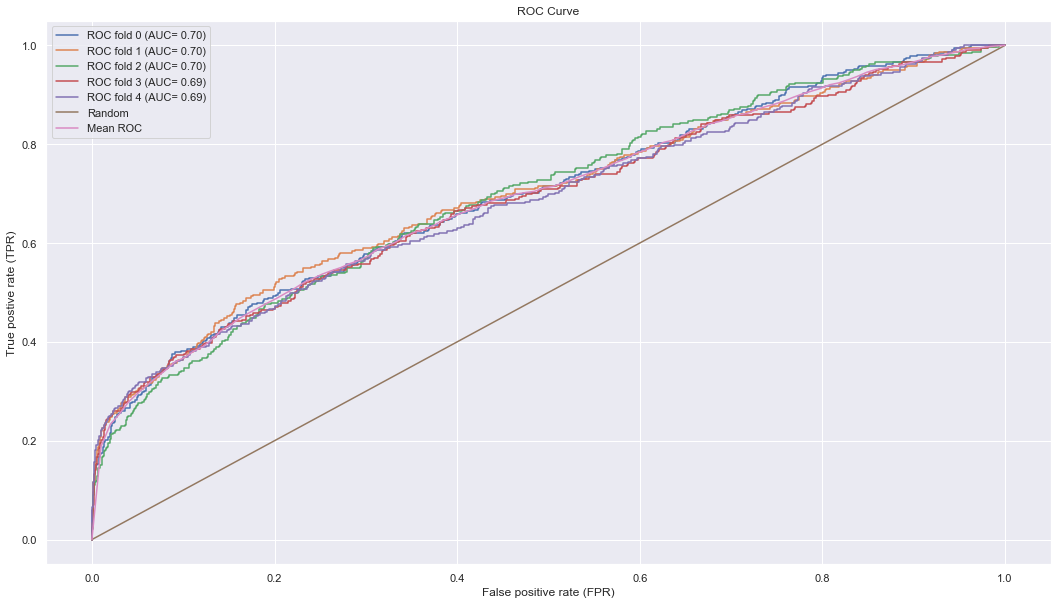

In [103]:
plot_roc_curve(fprs, tprs)
plt.show()

# Understanding the model

## Plot features ordered by their importance

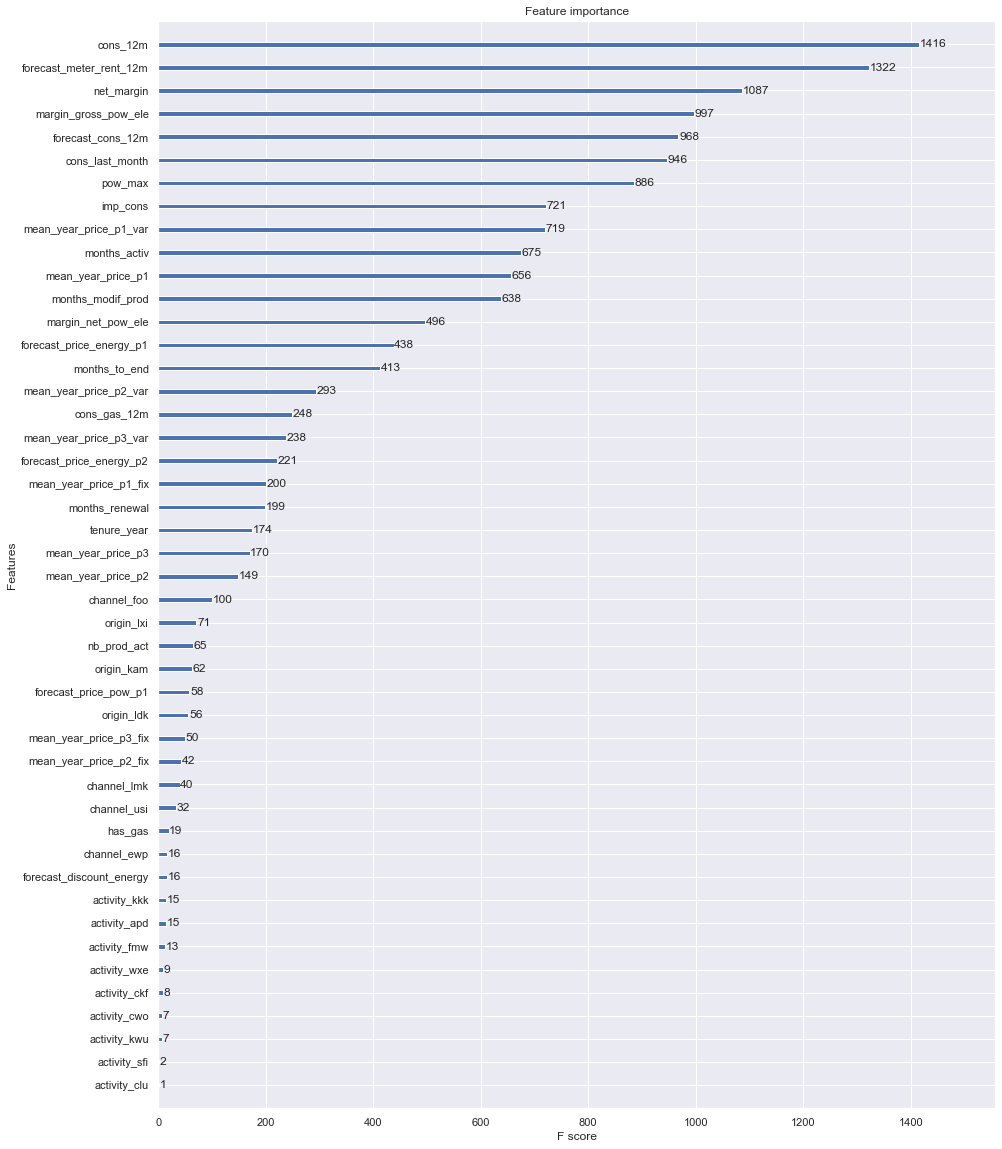

In [104]:
fig,ax= plt.subplots(figsize=(15,20))
xgb.plot_importance(model, ax=ax)